In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

INPUT_SIZE = 784
OUTPUT_SIZE = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.5
ITERATIONS_BATCHES = 10000


train_set = datasets.MNIST(root="data", download=True, transform=ToTensor())
test_set = datasets.MNIST(root="data",
                          download=True,
                          transform=ToTensor(),
                          train=False)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)




torch.Size([10, 784])
torch.Size([10])


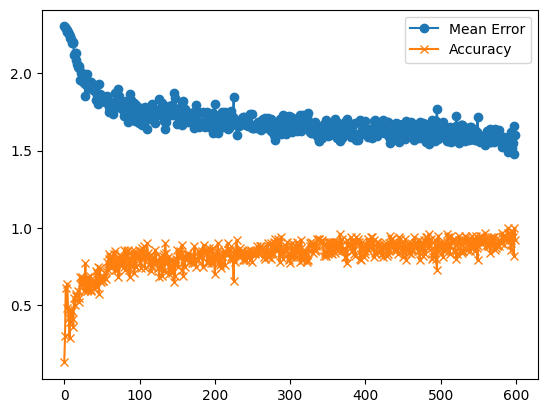

In [3]:
# Linear Model:
# for a linear model we need input and output dimension
import torch.nn as nn
import torch.optim as optim
from typing import Callable
import matplotlib.pyplot as plt

'''
The Softmax function : 
     Also called: softargmax or normalized exponential function.
     It converts a vector of K real numbers into a probability distribution of K possible outcomes.
     ==> for the multiclass classification
'''

class LinearModel(nn.Module):
     def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=input_size, out_features=output_size, bias=True)
        self.linear.weight.data = self.init_weights(input_size)
        self.linear.bias.data = self.init_bias(output_size)
        print(self.linear.weight.shape)
        print(self.linear.bias.shape)
        self.softmax = nn.Softmax(dim=1)
     
     def forward(self, x : torch.tensor):
          return self.linear(x)
     
     # we will use a softmax normalization
     def normalize(self, pred : torch.tensor):
          return self.softmax(pred)
     
     def flatten_batch_input(self, input_batch : torch.tensor)-> torch.tensor:
          flattened = input_batch.flatten(start_dim=1)
          return flattened
     
     def init_weights(self, input_size : int) -> torch.tensor:
          lists = [[0.0]*input_size for x in range(10) ]
          return torch.tensor(lists)

     def init_bias(self, output_size) -> torch.tensor:
          bias = [0.0] * output_size
          return torch.tensor(bias)
     
     # gives back the ratio between correctly classified and batch size
     def calculate_accuracy(self, pred: torch.tensor, actual : torch.tensor):

          counter_acc = 0
          counter = 0
          for row in pred:
               max_ind = torch.argmax(row)
               if max_ind == actual[counter]:
                    counter_acc += 1
               counter += 1
          
          return counter_acc / len(pred)


def train_linear_model(
          model : LinearModel,
          error_function : Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
          dataloader : DataLoader
                    ) -> list[float]:
     optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
     errors = []
     accuracies = []
     iterations_counter = 0
     epochs_counter = 0
     while iterations_counter < ITERATIONS_BATCHES:
          for batch, labels in dataloader:
               flat = model.flatten_batch_input(batch)
               out =  model.forward(flat)
               out_normalized = model.normalize(out)
               accuracy = model.calculate_accuracy(out_normalized, labels)
               loss = error_function(out_normalized, labels)
               optimizer.zero_grad()
               loss.backward() 
               optimizer.step()
               errors.append(loss.item())
               accuracies.append(accuracy)
               iterations_counter += BATCH_SIZE
          epochs_counter += 1

     return errors, accuracies, epochs_counter


model = LinearModel(INPUT_SIZE, OUTPUT_SIZE)
model.init_weights(INPUT_SIZE)

errors_linear_model, acc, number_epochs = train_linear_model(model, nn.CrossEntropyLoss(), train_loader)

def plot_linear_model(errors, acc):
     x_axis = list(range(len(errors)))
     plt.plot(x_axis, errors, label='Mean Error', marker='o')
     plt.plot(x_axis, acc , label='Accuracy', marker='x' )
     plt.legend()
     plt.show()

plot_linear_model(errors_linear_model, acc)





In [16]:
# functions for custom initializing weights
import numpy as np

def is_too_far(rand : float, mean: float, std : float) -> bool:
     upper = mean + 2 * std
     lower = mean - 2 * std
     return  (rand > upper or rand < lower)
          

def truncated_normal_two_std(x : int, y : int, mean : float , std : float)-> nn.Parameter:
     two_dim_arr = [[0.0] * y for _ in range(x)]
     for x in range(len(two_dim_arr) -1 ):
          for y in range(len(two_dim_arr[x]) -1):
               sample = np.random.normal(mean, std)
               while is_too_far(sample, mean=mean, std=std):
                    sample = np.random.normal(mean, std)

               two_dim_arr[x][y] = sample
     
     return nn.Parameter(torch.tensor(two_dim_arr), requires_grad=True)

     

def init_bias_with_constant(height : int) -> nn.Parameter:
     ten=  torch.tensor([(-0.1) ** 5.0 for _ in range(height)])
     return nn.Parameter(ten, requires_grad=True)

#print(truncated_normal_two_std(5, 5, 0, 0.01))
#print(init_bias_with_constant(10))


# The Adam Algorithm (Adaptive moment Estimation)

- a method for efficient stochastic optimization that only requires first order gradients
- stochasticity comes from: evaluation at random subsamples (minibatches) or noise
- the algorithm updates exponential moving averages of the gradient and the squared gradient
- the hyper parameters beta 1, 2 control the exponential decay of the moving averages

In [ ]:
'''
A second model: MLP with 3 Hidden Layers and 1500 

Weights and Biases will be initilazed with the functions above.

We use ReLu as an activation function for the Hidden layers.

We use Softmax as a normalization at the outputlayer
'''
import torch.nn.init as init

class MLP(nn.Module):

        def __init__(self, loss_function : Callable,   dimensions : list[int], activations : list[Callable], mean_weight :float, std_weight: float):
                super(MLP, self).__init__()
                self.loss_function = loss_function
                self.mean_weight = mean_weight
                self.std_weight = std_weight
                # in the input layer there is no activation
                assert len(activations) == len(dimensions) -1
                self.activations = activations
                self.layers = self.init_model_layers(dimensions=dimensions)


        def init_model_layers(self, dimensions : list[int])-> nn.ModuleList:
                layers = nn.ModuleList()
                for idx in range(1, len(dimensions) -1):
                        new_layer = nn.Linear(in_features=dimensions[idx -1],out_features=dimensions[idx],  bias=True)
                        self.init_weights(new_layer)
                        self.init_bias(new_layer)
                        layers.append(new_layer)
                return layers

        def forward(self, input : torch.tensor) -> torch.tensor:
                for index in range(len(self.layers)):
                        input = self.layers[index](input)
                        input = self.activations[index](input)
                return input
        
        def flatten_batch_input(self, input_batch : torch.tensor)-> torch.tensor:
                flattened = input_batch.flatten(start_dim=1)
                return flattened
        
        def init_weights(self, layer: nn.Linear):
                init.trunc_normal_(layer.weight, mean=self.mean_weight, std=self.std_weight, a=-2, b=2)

        def init_bias(self, layer: nn.Linear):
                ten=  torch.tensor([(-0.1) ** 5.0 for _ in range(height)])
                layer.bias =  nn.Parameter(ten, requires_grad=True)
        
        # gives back the ratio between correctly classified and batch size
        def calculate_accuracy(self, pred: torch.tensor, actual : torch.tensor):

          counter_acc = 0
          counter = 0
          for row in pred:
               max_ind = torch.argmax(row)
               if max_ind == actual[counter]:
                    counter_acc += 1
               counter += 1
          
          return counter_acc / len(pred)
        

def train_MLP_model(mlp_model : MLP, train_loader : DataLoader , iterations : int) -> tuple[list[float], list[float]]:
        # initlaized with the standard parameters
        optimizer = optim.Adam(mlp_model.parameters(), lr=0.001 )

        errors = []
        accuracies = []
        iterations_counter = 0
        while iterations_counter < iterations:
                for batch, labels in train_loader:
                        flat = model.flatten_batch_input(batch)
                        optimizer.zero_grad()
                        out =  model.forward(flat)
                        accuracy = model.calculate_accuracy(out, labels)
                        loss = model.loss_function(out, labels)
                        loss.backward() 
                        optimizer.step()
                        errors.append(loss.item())
                        accuracies.append(accuracy)
                        iterations_counter += 1

        return errors, accuracies


MEAN_WEIGHT = 0.0
WEIGHT_STD = 0.01

mlp_model = MLP(nn.CrossEntropyLoss, [784, 1500, 1500, 1500, 10], [nn.ReLU, nn.ReLU, nn.ReLU, nn.Softmax], MEAN_WEIGHT, std_weight=WEIGHT_STD)
print(list(mlp_model.parameters()))
#errors, accuracies = train_MLP_model(mlp_model,train_loader, 20000)

#plot_linear_model(errors=errors, acc=accuracies)

     

AttributeError: 'Linear' object has no attribute 'shape'

torch.Size([5, 10])
torch.Size([5])
